In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import string
from tensorflow.keras import regularizers, models, layers, optimizers
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

seed = 1234
np.random.seed(seed)
tf.random.set_seed(seed)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
images = np.load('/content/drive/MyDrive/Colab Notebooks/mds-misis-dl-captcha/data/images.npy')
labels = np.load('/content/drive/MyDrive/Colab Notebooks/mds-misis-dl-captcha/data/labels.npy')
images_pred = np.load('/content/drive/MyDrive/Colab Notebooks/mds-misis-dl-captcha/data/images_sub.npy')

## Some functions and variables needed

In [7]:
DIMENSIONS = len(set(labels)) # num of classes
BATCH_SIZE = 48

characters = set(labels)
letters = list(string.ascii_lowercase)
translit = {key : value for key, value in zip(characters, letters)}


def to_one_hot(labels, dimension: int = DIMENSIONS):
    result = np.zeros((len(labels),dimension))
    for i, label in enumerate(labels):
        result[i,label] = 1.
    return result


def visualize(images_array, nimgs: int) -> object :#, translit: dict, y=False, y_labels=None)  :
  ncols = int(nimgs / 2)
  _,ax = plt.subplots(nrows=2, ncols=ncols, figsize=(10,3))
  for i in range(nimgs):
      img = images_array[i]
      ax[i//ncols, i%ncols].imshow(img, cmap='gray')
      ax[i//ncols, i%ncols].axis('off')
      # if y:
      #   ax.set_title('Label: {}'.format(translit.get(y_labels[i],)))
  plt.show()


def show_loss_graph(history, metric: str):
  #metric - accuracy or loss
  metr = history.history[f'{metric}']
  val_metr = history.history[f'val_{metric}']
  epochs = range(1, len(metr) + 1)

  plt.plot(epochs, metr, 'bo', label=f'Training {metric}')
  plt.plot(epochs, val_metr, 'b', label=f'Validation {metric}')
  plt.title(f'Training and validation {metric}')
  plt.legend()

  plt.show()


def generator_visualize(generator, num_imgs: int, batch_size: int =BATCH_SIZE) -> object:
  n_rows = 2
  n_cols = num_imgs // n_rows
  try:
    fig2, axes2 = plt.subplots(n_rows, n_cols, figsize=(1.5*n_cols,2*n_rows))
    for X, Y in generator:
        for i in range(0, batch_size):
              ax = axes2[i//n_cols, i%n_cols]
              ax.imshow(X[i].reshape(48,48,3), cmap='gray_r')
              #ax.set_title('Label: {}'.format(int(Y[i])))
        break
    plt.tight_layout()
    plt.show()
  except IndexError:
    pass


def to_black_white(x_array, separator: float):
  #test = x_array.copy()
  #separator = 1.2 # 255 / 0.8 / 2 * 3 / 255 
  x_array = x_array / 255
  all_black = np.zeros((48,48,3))
  all_white = np.ones((48,48,3))

  for img_num, img in enumerate(x_array):
    for w_num, w in enumerate(img):
      for h_num, h in enumerate(w):
        if sum(h) > separator:
          x_array[img_num,w_num,h_num] = [1., 1., 1.]
        else:
          x_array[img_num,w_num,h_num] = [0., 0., 0.]

  a = []
  for img_num, img in enumerate(x_array):
    if np.logical_and(img == all_black, all_black == img).all():
      a.append(img_num)
    if np.logical_and(img == all_white, all_white == img).all():
      a.append(img_num)

  x_array = np.delete(x_array, a, axis=0)

  return x_array


def make_standard(array):
  return (array / 255).astype(np.float32)


def make_noise(array):
  return make_standard(array) - np.random.normal(0, 0.2, array.shape)

## Extra info about data

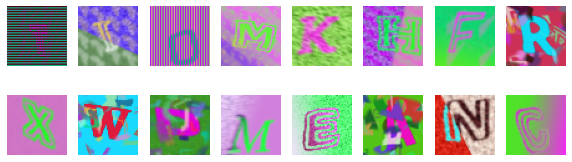

In [ ]:
# We are to predict the following examples. 
visualize(images_pred, 16)

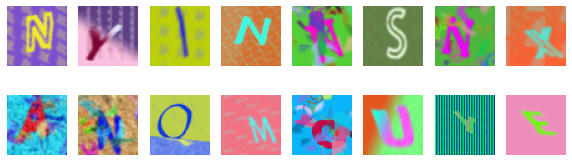

In [ ]:
# Let's take a look at some samples first. 
visualize(images, 16)

In [ ]:
print(f"All possible classes of characters in CAPTCHAs: {characters}.")
print(f"Letters in CAPTCHAs by class: {letters}.")

In [ ]:
print(f"Dataset shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
#print(f"Prediction data shape: {images_pred.shape}")

## MODELLING ONLY BASIC IMAGES

#### Data transformation

In [6]:
# Get train, test, validate
# _data include train and validation

x_data, x_test, y_data, y_test = train_test_split(images, labels,
                                                   stratify=labels,
                                                   shuffle=True,
                                                   test_size=0.1)
x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data,
                                                   stratify=y_data,
                                                   shuffle=True,
                                                   test_size=0.15)

In [7]:
y_train_one_hot = to_one_hot(y_train).astype('float32')
y_test_one_hot = to_one_hot(y_test).astype('float32')
y_valid_one_hot = to_one_hot(y_valid).astype('float32')

#### Modelling #1

##### Learning with validation to fecth the architecture

In [8]:
model = models.Sequential([

    # first conv block                     
    layers.Conv2D(32, kernel_size=(3,3), 
                  activation='relu', 
                  padding='same', 
                  kernel_initializer='he_normal',
                  kernel_regularizer=regularizers.l2(l2=0.01), 
                  input_shape=(48,48,3)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # second conv block  
    layers.Conv2D(64, kernel_size=(3,3), 
                  activation='relu', 
                  padding='same', 
                  kernel_initializer='he_normal',
                  ),
    #layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # third conv block  
    layers.Conv2D(128, kernel_size=(3,3), 
                  activation='relu', 
                  padding='same', 
                  ),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # third conv block  
    layers.Conv2D(128, kernel_size=(3,3), 
                  activation='relu', 
                  padding='same', 
                  ),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    # Classes
    layers.Dense(DIMENSIONS,
              activation='softmax',)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 128)         1

In [9]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.1,
        shear_range=0.2,
        
        zoom_range=[0.8,1.2],
        brightness_range=(0.5,1.5),
        channel_shift_range=0.5,
        horizontal_flip=False,    
    )

valid_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow(
        x_train, y_train_one_hot,
        batch_size=BATCH_SIZE)

validation_generator = valid_datagen.flow(
        x_valid, y_valid_one_hot,
        batch_size=BATCH_SIZE)

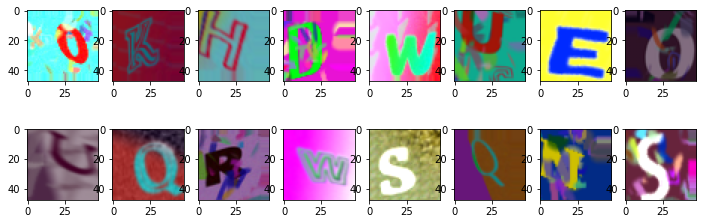

In [10]:
generator_visualize(train_generator, 16, )

In [11]:
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])

In [13]:
EPOCHS = 150
CHECKPOINT_NAME = '/content/drive/MyDrive/Colab Notebooks/Capcha_model.hdf5'

# # Save weights only for best model
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = CHECKPOINT_NAME, 
                               verbose = 2, 
                               save_best_only = True)

# Reduce learning rate when a metric has stopped improving
lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', #'val_loss'
                                 patience=10, 
                                 verbose=2, 
                                 factor=.75)

# If score doesn't improve during patience=20 epochs, stop learning
estopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', #'val_loss'
                          patience=20, 
                          verbose=2)

# # Training

history = model.fit(train_generator,
                        # x_train, y_train_one_hot,
                        #batch_size = BATCH_SIZE,
                        steps_per_epoch=len(x_train) / BATCH_SIZE,
                        epochs = EPOCHS,
                        verbose = 1,
                        #validation_data = (x_test, y_test_one_hot),
                        validation_data = validation_generator,
                        validation_steps=len(x_valid) / BATCH_SIZE,
                        callbacks = [checkpointer, lr_reduction, estopping]
)

Epoch 1/150
318/318 [==============================] - 18s 57ms/step - loss: 2.6752 - accuracy: 0.2532 - val_loss: 1.9393 - val_accuracy: 0.4593

Epoch 00001: val_loss improved from inf to 1.93931, saving model to /content/drive/MyDrive/Colab Notebooks/Capcha_model.hdf5
Epoch 2/150
318/318 [==============================] - 18s 57ms/step - loss: 1.9769 - accuracy: 0.4420 - val_loss: 1.3460 - val_accuracy: 0.6248

Epoch 00002: val_loss improved from 1.93931 to 1.34599, saving model to /content/drive/MyDrive/Colab Notebooks/Capcha_model.hdf5
Epoch 3/150
318/318 [==============================] - 18s 57ms/step - loss: 1.5801 - accuracy: 0.5516 - val_loss: 1.1488 - val_accuracy: 0.6881

Epoch 00003: val_loss improved from 1.34599 to 1.14885, saving model to /content/drive/MyDrive/Colab Notebooks/Capcha_model.hdf5
Epoch 4/150
318/318 [==============================] - 18s 57ms/step - loss: 1.3289 - accuracy: 0.6232 - val_loss: 0.8900 - val_accuracy: 0.7600

Epoch 00004: val_loss improved fr

In [14]:
loss, acc = model.evaluate((x_test / 255).astype(np.float32), y_test_one_hot, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

63/63 - 1s - loss: 0.2466 - accuracy: 0.9330
Restored model, accuracy: 93.30%


##### Loss visualization

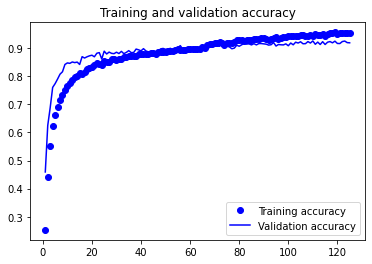

In [15]:
# Accuracy

show_loss_graph(history, 'accuracy')

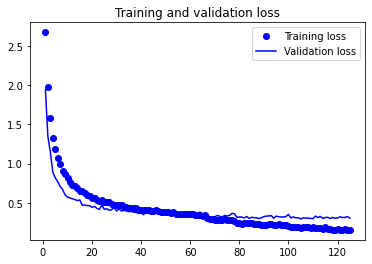

In [16]:
# Loss

show_loss_graph(history, 'loss')

##### Learning on the whole data

In [ ]:
X = np.concatenate((x_train, x_valid, x_test), axis=0)
Y_one_hot = np.concatenate((y_train_one_hot, y_valid_one_hot, y_test_one_hot), axis=0)

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.1,
        shear_range=0.2,
        
        zoom_range=[0.8,1.2],
        brightness_range=(0.5,1.5),
        channel_shift_range=0.5,
        horizontal_flip=False,    
    )

train_generator = train_datagen.flow(
        X, Y_one_hot,
        batch_size=BATCH_SIZE)

In [ ]:
# # Training
model = models.Sequential([

    # first conv block                     
    layers.Conv2D(32, kernel_size=(3,3), 
                  activation='relu', 
                  padding='same', 
                  kernel_initializer='he_normal',
                  kernel_regularizer=regularizers.l2(l2=0.01), 
                  input_shape=(48,48,3)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # second conv block  
    layers.Conv2D(64, kernel_size=(3,3), 
                  activation='relu', 
                  padding='same', 
                  kernel_initializer='he_normal',
                  ),
    #layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # third conv block  
    layers.Conv2D(128, kernel_size=(3,3), 
                  activation='relu', 
                  padding='same', 
                  ),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # third conv block  
    layers.Conv2D(128, kernel_size=(3,3), 
                  activation='relu', 
                  padding='same', 
                  ),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    # Classes
    layers.Dense(DIMENSIONS,
              activation='softmax',)
])

model.summary()
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])


EPOCHS = 100
CHECKPOINT_NAME = 'Capcha_model1_1.hdf5'

# # Save weights only for best model
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = CHECKPOINT_NAME, 
                               verbose = 2, 
                               save_best_only = True)

# Reduce learning rate when a metric has stopped improving
lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', #'val_loss'
                                 patience=5, 
                                 verbose=2, 
                                 factor=.75)

# If score doesn't improve during patience=20 epochs, stop learning
estopping = tf.keras.callbacks.EarlyStopping(monitor='loss', #'val_loss'
                          patience=20, 
                          verbose=2)

res = model.fit(train_generator,
                        # x_train, y_train_one_hot,
                        #batch_size = BATCH_SIZE,
                        steps_per_epoch=len(X) / BATCH_SIZE,
                        epochs = EPOCHS,
                        verbose = 1,
                callbacks = [checkpointer, lr_reduction, estopping]
        )
model.save('my_model1.h5')
model.save('my_model_1.hdf5')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 6, 6, 128)        

#### Modelling #2

##### Learning with validation to fecth the architecture

In [17]:
# Model 2

model2 = models.Sequential([

    # first conv block                     
    layers.Conv2D(32, kernel_size=(3,3), 
                  activation='relu', 
                  padding='same', 
                  kernel_initializer='he_normal',
                  kernel_regularizer=regularizers.l2(l2=0.01), 
                  input_shape=(48,48,3)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # second conv block  
    layers.Conv2D(64, kernel_size=(3,3), 
                  activation='relu', 
                  padding='same', 
                  kernel_initializer='he_normal',
                  ),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # third conv block  
    layers.Conv2D(128, kernel_size=(3,3), 
                  activation='relu', 
                  padding='same', 
                  ),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # third conv block  
    layers.Conv2D(128, kernel_size=(3,3), 
                  activation='relu', 
                  padding='same', 
                  ),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    # Classes
    layers.Dense(DIMENSIONS,
              activation='softmax',)
])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 64)       

In [18]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.1,
        shear_range=0.2,
        
        zoom_range=[0.8,1.2],
        brightness_range=(0.5,1.5),
        channel_shift_range=0.5,
        horizontal_flip=False,    
    )

valid_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow(
        x_train, y_train_one_hot,
        batch_size=BATCH_SIZE)

validation_generator = valid_datagen.flow(
        x_valid, y_valid_one_hot,
        batch_size=BATCH_SIZE)

In [19]:
model2.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])

In [20]:
EPOCHS = 300
CHECKPOINT_NAME = '/content/drive/MyDrive/Colab Notebooks/Capcha_model_2.hdf5'

# # Save weights only for best model
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = CHECKPOINT_NAME, 
                               verbose = 2, 
                               save_best_only = True)

# Reduce learning rate when a metric has stopped improving
lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', #'val_loss'
                                 patience=10, 
                                 verbose=2, 
                                 factor=.75)

# If score doesn't improve during patience=20 epochs, stop learning
estopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', #'val_loss'
                          patience=20, 
                          verbose=2)

# # Training

history2 = model2.fit(train_generator,
                        # x_train, y_train_one_hot,
                        #batch_size = BATCH_SIZE,
                        steps_per_epoch=len(x_train) / BATCH_SIZE,
                        epochs = EPOCHS,
                        verbose = 1,
                        #validation_data = (x_test, y_test_one_hot),
                        validation_data = validation_generator,
                        validation_steps=len(x_valid) / BATCH_SIZE,
                        callbacks = [checkpointer, lr_reduction, estopping]
)

Epoch 1/300
318/318 [==============================] - 19s 58ms/step - loss: 4.2096 - accuracy: 0.0472 - val_loss: 3.8597 - val_accuracy: 0.0374

Epoch 00001: val_loss improved from inf to 3.85972, saving model to /content/drive/MyDrive/Colab Notebooks/Capcha_model_2.hdf5
Epoch 2/300
318/318 [==============================] - 18s 57ms/step - loss: 3.5933 - accuracy: 0.0560 - val_loss: 3.5950 - val_accuracy: 0.0807

Epoch 00002: val_loss improved from 3.85972 to 3.59503, saving model to /content/drive/MyDrive/Colab Notebooks/Capcha_model_2.hdf5
Epoch 3/300
318/318 [==============================] - 18s 57ms/step - loss: 3.0478 - accuracy: 0.1677 - val_loss: 2.4170 - val_accuracy: 0.3315

Epoch 00003: val_loss improved from 3.59503 to 2.41698, saving model to /content/drive/MyDrive/Colab Notebooks/Capcha_model_2.hdf5
Epoch 4/300
318/318 [==============================] - 18s 57ms/step - loss: 2.1209 - accuracy: 0.4223 - val_loss: 1.4404 - val_accuracy: 0.6359

Epoch 00004: val_loss impro

In [21]:
loss, acc = model2.evaluate((x_test / 255).astype(np.float32), y_test_one_hot, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

63/63 - 0s - loss: 0.2506 - accuracy: 0.9250
Restored model, accuracy: 92.50%


##### Loss visualization

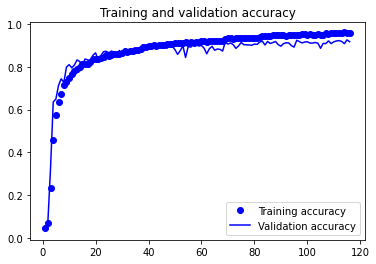

In [22]:
# Accuracy

show_loss_graph(history2, 'accuracy')

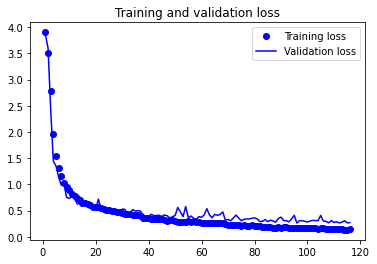

In [23]:
# Loss

show_loss_graph(history2, 'loss')

##### Learning on the whole data

In [ ]:
X = np.concatenate((x_train, x_valid, x_test), axis=0)
Y_one_hot = np.concatenate((y_train_one_hot, y_valid_one_hot, y_test_one_hot), axis=0)

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.1,
        shear_range=0.2,
        
        zoom_range=[0.8,1.2],
        brightness_range=(0.5,1.5),
        channel_shift_range=0.5,
        horizontal_flip=False,    
    )

train_generator = train_datagen.flow(
        X, Y_one_hot,
        batch_size=BATCH_SIZE)

In [ ]:
# # Training
model = models.Sequential([

    # first conv block                     
    layers.Conv2D(32, kernel_size=(3,3), 
                  activation='relu', 
                  padding='same', 
                  kernel_initializer='he_normal',
                  kernel_regularizer=regularizers.l2(l2=0.01), 
                  input_shape=(48,48,3)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # second conv block  
    layers.Conv2D(64, kernel_size=(3,3), 
                  activation='relu', 
                  padding='same', 
                  kernel_initializer='he_normal',
                  ),
    #layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # third conv block  
    layers.Conv2D(128, kernel_size=(3,3), 
                  activation='relu', 
                  padding='same', 
                  ),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # third conv block  
    layers.Conv2D(128, kernel_size=(3,3), 
                  activation='relu', 
                  padding='same', 
                  ),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    # Classes
    layers.Dense(DIMENSIONS,
              activation='softmax',)
])

model.summary()
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])


EPOCHS = 100
CHECKPOINT_NAME = 'Capcha_model1_1.hdf5'

# # Save weights only for best model
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = CHECKPOINT_NAME, 
                               verbose = 2, 
                               save_best_only = True)

# Reduce learning rate when a metric has stopped improving
lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', #'val_loss'
                                 patience=5, 
                                 verbose=2, 
                                 factor=.75)

# If score doesn't improve during patience=20 epochs, stop learning
estopping = tf.keras.callbacks.EarlyStopping(monitor='loss', #'val_loss'
                          patience=20, 
                          verbose=2)

res = model.fit(train_generator,
                        # x_train, y_train_one_hot,
                        #batch_size = BATCH_SIZE,
                        steps_per_epoch=len(X) / BATCH_SIZE,
                        epochs = EPOCHS,
                        verbose = 1,
                callbacks = [checkpointer, lr_reduction, estopping]
        )
model.save('my_model1.h5')
model.save('my_model_1.hdf5')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 6, 6, 128)        

## MODELLING NOISED IMAGES

In [24]:
images = np.load('/content/drive/MyDrive/Colab Notebooks/mds-misis-dl-captcha/data/images.npy')
labels = np.load('/content/drive/MyDrive/Colab Notebooks/mds-misis-dl-captcha/data/labels.npy')
images_pred = np.load('/content/drive/MyDrive/Colab Notebooks/mds-misis-dl-captcha/data/images_sub.npy')

### Make noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

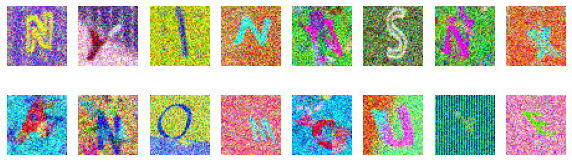

In [25]:
visualize(make_noise(images), 16)

In [ ]:
del images_noise

### Data transformation

In [26]:
# Get train, test, validate
# To check if model is better we should use the same train_val_test split

x_train_noise = make_noise(x_train)

# Concatenate togeter the normalized train (than test) set with noise and the one without noise

x_train_with_noise = np.concatenate((make_standard(x_train), x_train_noise), axis=0)
y_train_for_noisedx = np.concatenate((y_train, y_train), axis=0)

y_train_one_hot_for_noisedx = to_one_hot(y_train_for_noisedx).astype('float32')

print(x_train_with_noise.shape)
print(y_train_one_hot_for_noisedx.shape)

(30600, 48, 48, 3)
(30600, 26)


### Modelling #1

#### Learning with validation to fecth the architecture

In [27]:
model_noised = models.Sequential([

    # first conv block                     
    layers.Conv2D(32, kernel_size=(3,3), 
                  activation='relu', 
                  padding='same', 
                  kernel_initializer='he_normal',
                  kernel_regularizer=regularizers.l2(l2=0.01), 
                  input_shape=(48,48,3)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # second conv block  
    layers.Conv2D(64, kernel_size=(3,3), 
                  activation='relu', 
                  padding='same', 
                  kernel_initializer='he_normal',
                  ),
    #layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # third conv block  
    layers.Conv2D(128, kernel_size=(3,3), 
                  activation='relu', 
                  padding='same', 
                  ),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # third conv block  
    layers.Conv2D(128, kernel_size=(3,3), 
                  activation='relu', 
                  padding='same', 
                  ),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    # Classes
    layers.Dense(DIMENSIONS,
              activation='softmax',)
])

model_noised.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 6, 6, 128)        

In [28]:
train_datagen = ImageDataGenerator(
#        rescale=1./255, #alredy standartized
        width_shift_range=0.2,
        height_shift_range=0.1,
        shear_range=0.2,
        
        zoom_range=[0.8,1.2],
        #brightness_range=(0.5,1.5),
        channel_shift_range=0.5,
        horizontal_flip=False,    
    )

valid_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow(
        x_train_with_noise, y_train_one_hot_for_noisedx,
        batch_size=BATCH_SIZE)

validation_generator = valid_datagen.flow(
        x_valid, y_valid_one_hot,
        batch_size=BATCH_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


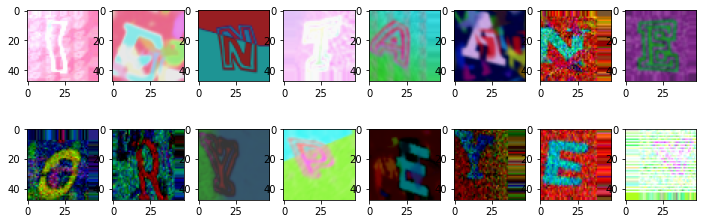

In [29]:
generator_visualize(train_generator, 16, )

In [31]:
model_noised.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])

In [32]:
EPOCHS = 300
CHECKPOINT_NAME = '/content/drive/MyDrive/Colab Notebooks/Capcha_noised.hdf5'

# # Save weights only for best model
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = CHECKPOINT_NAME, 
                               verbose = 2, 
                               save_best_only = True)

# Reduce learning rate when a metric has stopped improving
lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', #'val_loss'
                                 patience=6, 
                                 verbose=2, 
                                 factor=.75)

# If score doesn't improve during patience=20 epochs, stop learning
estopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', #'val_loss'
                          patience=20, 
                          verbose=2)

# # Training

history_noised_2 = model_noised.fit(train_generator,
                        # x_train, y_train_one_hot,
                        #batch_size = BATCH_SIZE,
                        steps_per_epoch=len(x_train_with_noise) / BATCH_SIZE,
                        epochs = EPOCHS,
                        verbose = 1,
                        #validation_data = (x_test, y_test_one_hot),
                        validation_data = validation_generator,
                        validation_steps=len(x_valid) / BATCH_SIZE,
                        callbacks = [checkpointer, lr_reduction, estopping]
)

Epoch 1/300
637/637 [==============================] - 29s 44ms/step - loss: 3.6120 - accuracy: 0.0465 - val_loss: 3.0443 - val_accuracy: 0.1174

Epoch 00001: val_loss improved from inf to 3.04428, saving model to /content/drive/MyDrive/Colab Notebooks/Capcha_noised.hdf5
Epoch 2/300
637/637 [==============================] - 28s 43ms/step - loss: 2.8462 - accuracy: 0.1830 - val_loss: 1.5153 - val_accuracy: 0.5570

Epoch 00002: val_loss improved from 3.04428 to 1.51530, saving model to /content/drive/MyDrive/Colab Notebooks/Capcha_noised.hdf5
Epoch 3/300
637/637 [==============================] - 28s 44ms/step - loss: 1.9502 - accuracy: 0.4223 - val_loss: 1.0414 - val_accuracy: 0.6956

Epoch 00003: val_loss improved from 1.51530 to 1.04144, saving model to /content/drive/MyDrive/Colab Notebooks/Capcha_noised.hdf5
Epoch 4/300
637/637 [==============================] - 28s 43ms/step - loss: 1.5572 - accuracy: 0.5418 - val_loss: 0.8845 - val_accuracy: 0.7485

Epoch 00004: val_loss improved

In [33]:
loss, acc = model_noised.evaluate((x_test / 255).astype(np.float32), y_test_one_hot, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

63/63 - 0s - loss: 0.3143 - accuracy: 0.9170
Restored model, accuracy: 91.70%


#### Loss visualization

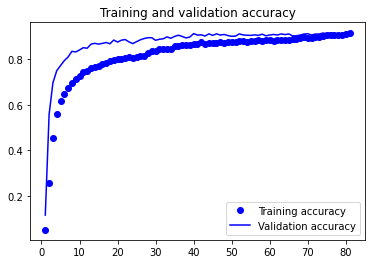

In [34]:
# Accuracy

show_loss_graph(history_noised_2, 'accuracy')

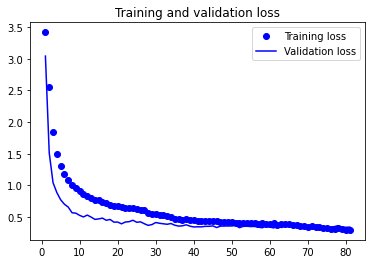

In [35]:
# Loss

show_loss_graph(history_noised_2, 'loss')

#### Learning on the whole data

In [ ]:
X_train = np.concatenate((x_train, x_valid), axis=0)
Y_train_one_hot = np.concatenate((y_train_one_hot, y_valid_one_hot), axis=0)

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.1,
        shear_range=0.2,
        
        zoom_range=[0.8,1.2],
        brightness_range=(0.5,1.5),
        channel_shift_range=0.5,
        horizontal_flip=False,    
    )

train_generator = train_datagen.flow(
        X_train, Y_train_one_hot,
        batch_size=BATCH_SIZE)

In [ ]:
# # Training

res = model.fit(train_generator,
                        # x_train, y_train_one_hot,
                        #batch_size = BATCH_SIZE,
                        steps_per_epoch=len(x_train) / BATCH_SIZE,
                        epochs = EPOCHS,
                        verbose = 1,
        )

### Modelling #2

#### Learning with validation to fecth the architecture

In [36]:
model2_noised = models.Sequential([

    # first conv block                     
    layers.Conv2D(32, kernel_size=(3,3), 
                  activation='relu', 
                  padding='same', 
                  kernel_initializer='he_normal',
                  kernel_regularizer=regularizers.l2(l2=0.01), 
                  input_shape=(48,48,3)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # second conv block  
    layers.Conv2D(64, kernel_size=(3,3), 
                  activation='relu', 
                  padding='same', 
                  kernel_initializer='he_normal',
                  ),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # third conv block  
    layers.Conv2D(128, kernel_size=(3,3), 
                  activation='relu', 
                  padding='same', 
                  ),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # third conv block  
    layers.Conv2D(128, kernel_size=(3,3), 
                  activation='relu', 
                  padding='same', 
                  ),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    # Classes
    layers.Dense(DIMENSIONS,
              activation='softmax',)
])

model2_noised.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
dropout_6 (Dropout)          (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
dropout_7 (Dropout)          (None, 24, 24, 64)       

In [37]:
train_datagen = ImageDataGenerator(
#        rescale=1./255, #alredy standartized
        width_shift_range=0.2,
        height_shift_range=0.1,
        shear_range=0.2,
        
        zoom_range=[0.8,1.2],
        #brightness_range=(0.5,1.5),
        channel_shift_range=0.5,
        horizontal_flip=False,    
    )

valid_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow(
        x_train_with_noise, y_train_one_hot_for_noisedx,
        batch_size=BATCH_SIZE)

validation_generator = valid_datagen.flow(
        x_valid, y_valid_one_hot,
        batch_size=BATCH_SIZE)

In [38]:
model2_noised.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])

In [39]:
EPOCHS = 300
CHECKPOINT_NAME = '/content/drive/MyDrive/Colab Notebooks/Capcha_noised_2.hdf5'

# # Save weights only for best model
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = CHECKPOINT_NAME, 
                               verbose = 2, 
                               save_best_only = True)

# Reduce learning rate when a metric has stopped improving
lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', #'val_loss'
                                 patience=6, 
                                 verbose=2, 
                                 factor=.75)

# If score doesn't improve during patience=20 epochs, stop learning
estopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', #'val_loss'
                          patience=20, 
                          verbose=2)

# # Training

history2_noised = model2_noised.fit(train_generator,
                        # x_train, y_train_one_hot,
                        #batch_size = BATCH_SIZE,
                        steps_per_epoch=len(x_train_with_noise) / BATCH_SIZE,
                        epochs = EPOCHS,
                        verbose = 1,
                        #validation_data = (x_test, y_test_one_hot),
                        validation_data = validation_generator,
                        validation_steps=len(x_valid) / BATCH_SIZE,
                        callbacks = [checkpointer, lr_reduction, estopping]
)

Epoch 1/300
637/637 [==============================] - 29s 45ms/step - loss: 4.0988 - accuracy: 0.0453 - val_loss: 3.4677 - val_accuracy: 0.0441

Epoch 00001: val_loss improved from inf to 3.46766, saving model to /content/drive/MyDrive/Colab Notebooks/Capcha_noised_2.hdf5
Epoch 2/300
637/637 [==============================] - 28s 44ms/step - loss: 3.3760 - accuracy: 0.0555 - val_loss: 3.2355 - val_accuracy: 0.0715

Epoch 00002: val_loss improved from 3.46766 to 3.23552, saving model to /content/drive/MyDrive/Colab Notebooks/Capcha_noised_2.hdf5
Epoch 3/300
637/637 [==============================] - 28s 44ms/step - loss: 3.0643 - accuracy: 0.1100 - val_loss: 1.8640 - val_accuracy: 0.4533

Epoch 00003: val_loss improved from 3.23552 to 1.86397, saving model to /content/drive/MyDrive/Colab Notebooks/Capcha_noised_2.hdf5
Epoch 4/300
637/637 [==============================] - 28s 44ms/step - loss: 2.0759 - accuracy: 0.3821 - val_loss: 1.2322 - val_accuracy: 0.6426

Epoch 00004: val_loss im

In [40]:
loss, acc = model2_noised.evaluate((x_test / 255).astype(np.float32), y_test_one_hot, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

63/63 - 0s - loss: 0.1808 - accuracy: 0.9415
Restored model, accuracy: 94.15%


#### Loss visualization

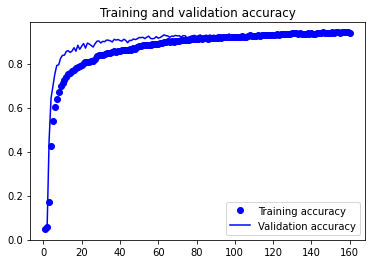

In [41]:
# Accuracy

show_loss_graph(history2_noised, 'accuracy')

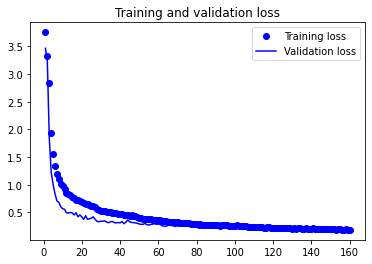

In [42]:
# Loss

show_loss_graph(history2_noised, 'loss')

###### It seems that leraning on data added with noisy images looks great!

In [43]:
loss, acc = model.evaluate((x_test / 255).astype(np.float32), y_test_one_hot, verbose=2)
print('Restored model without noise, accuracy: {:5.2f}%'.format(100 * acc))

loss, acc = model_noised.evaluate((x_test / 255).astype(np.float32), y_test_one_hot, verbose=2)
print('Restored model with noise, accuracy: {:5.2f}%'.format(100 * acc))

loss, acc = model2.evaluate((x_test / 255).astype(np.float32), y_test_one_hot, verbose=2)
print('Restored model without noise, accuracy: {:5.2f}%'.format(100 * acc))

loss, acc = model2_noised.evaluate((x_test / 255).astype(np.float32), y_test_one_hot, verbose=2)
print('Restored model with noise, accuracy: {:5.2f}%'.format(100 * acc))

63/63 - 0s - loss: 0.2466 - accuracy: 0.9330
Restored model without noise, accuracy: 93.30%
63/63 - 0s - loss: 0.3143 - accuracy: 0.9170
Restored model with noise, accuracy: 91.70%
63/63 - 0s - loss: 0.2506 - accuracy: 0.9250
Restored model without noise, accuracy: 92.50%
63/63 - 0s - loss: 0.1808 - accuracy: 0.9415
Restored model with noise, accuracy: 94.15%


#### Learning on the whole data

In [ ]:
X_train = np.concatenate((x_train, x_valid), axis=0)
Y_train_one_hot = np.concatenate((y_train_one_hot, y_valid_one_hot), axis=0)

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.1,
        shear_range=0.2,
        
        zoom_range=[0.8,1.2],
        brightness_range=(0.5,1.5),
        channel_shift_range=0.5,
        horizontal_flip=False,    
    )

train_generator = train_datagen.flow(
        X_train, Y_train_one_hot,
        batch_size=BATCH_SIZE)

In [ ]:
# # Training

res = model.fit(train_generator,
                        # x_train, y_train_one_hot,
                        #batch_size = BATCH_SIZE,
                        steps_per_epoch=len(x_train) / BATCH_SIZE,
                        epochs = EPOCHS,
                        verbose = 1,
        )

## Make prediction

In [5]:
# Load model
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Capcha_model.hdf5')
model1 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Capcha_model_2.hdf5')
model_noise = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Capcha_noised.hdf5')
model_noise2 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Capcha_noised_2.hdf5')

# Check its architecture
# model.summary()

In [ ]:
# Check the accuracy on test
# loss, acc = new_model.evaluate(make_standard(x_test), y_test_one_hot, verbose=2)
# print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

94/94 - 6s - loss: 0.7345 - accuracy: 0.8117
Restored model, accuracy: 81.17%


In [8]:
images_pred = make_standard(images_pred)

In [10]:
pred = model_noise2.predict_classes(images_pred)
pred2 = model_noise.predict_classes(images_pred)
pred3 = model.predict_classes(images_pred)
pred4 = model1.predict_classes(images_pred)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [11]:
for id, subm in enumerate([pred,pred2,pred3,pred4]):
  submission = pd.DataFrame({'Id': list(range(len(pred))), 'Category': subm})
  submission.to_csv(f'/content/drive/MyDrive/Colab Notebooks/capcha_mod{id+1}.csv', index=False)

In [12]:
sub1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/capcha_mod1.csv')
sub2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/capcha_mod2.csv')
sub3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/capcha_mod3.csv')
sub4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/capcha_mod4.csv')

In [14]:
similar = 0
different = 0

for el1, el2, el3, el4 in zip(sub1['Category'],sub2['Category'],sub3['Category'],sub4['Category']):
  if el1 == el2 == el3 == el4:
    similar += 1
  else:
    different += 1

print(f'Submissions are similar in {similar} cases and different - in {different} cases.')

Submissions are similar in 42573 cases and different - in 7427 cases.


In [19]:
import operator

subm = []

for el1, el2, el3, el4 in zip(sub1['Category'],sub2['Category'],sub3['Category'],sub4['Category']):
  if el1 == el2 == el3 == el4:
    subm.append(el1)
  else:
    possible_decision = {}
    for el in [el1,el2,el3,el4]:
      if possible_decision.get(el) == None:
        possible_decision[el] = 1
      else:
        possible_decision[el] = possible_decision.get(el) + 1
    decision = max(possible_decision, key=lambda k: possible_decision[k])
    subm.append(decision)

In [23]:
submission = pd.DataFrame({'Id': list(range(len(subm))), 'Category': subm})
submission.to_csv(f'/content/drive/MyDrive/Colab Notebooks/capcha_mod_agg.csv', index=False)

In [21]:
#[translit.get(label) for label in submission.Category.to_list()[:16]]
[translit.get(label) for label in subm[:32]]

['t',
 'i',
 'o',
 'm',
 'k',
 'h',
 'f',
 'r',
 'x',
 'w',
 'b',
 'm',
 'e',
 'a',
 'n',
 'g',
 'd',
 'l',
 't',
 'c',
 'd',
 'b',
 'o',
 'y',
 'f',
 'w',
 'q',
 'p',
 'a',
 'q',
 'u',
 'v']

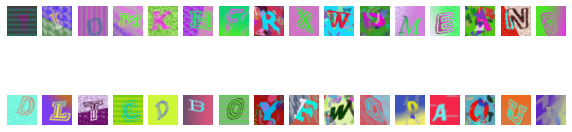

In [22]:
visualize(images_array=images_pred, nimgs=32)

# # # We are to predict the following examples. 
# _,ax = plt.subplots(nrows=2, ncols=4, figsize=(5,3))
# for i in range(8):
#     img = images_pred[i]
#     ax[i//4, i%4].imshow(img, cmap='gray')
#     ax[i//4, i%4].axis('off')
#     ax.set_title('Label: {}'.format(translit.get(y_labels[i],)))
# plt.show()

## MODELLING FILTERED IMAGES (In progress, not ready yet)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

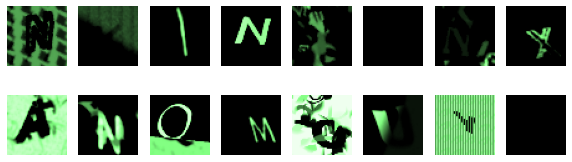

In [ ]:
images_agg = images[0:16] #* 255

# # Edge Detection1 NO
# identity = np.array([[0, -1, 0],
#               [-1, 4, -1],
#               [0, -1, 0]])
# Edge Detection2 NO
# identity = np.array([[-1, -1, -1],
#               [-1, 8, -1],
#               [-1, -1, -1]])
# Bottom Sobel Filter MB
identity = np.array([[-1, -2, -1],
              [0, 0, 0],
              [1, 2, 1]])
# Top Sobel Filter MB
# identity = np.array([[1, 2, 1],
#               [0, 0, 0],
#               [-1, -2, -1]])
# # Left Sobel Filter NO
# identity = np.array([[1, 0, -1],
#               [2, 0, -2],
#               [1, 0, -1]])
# Right Sobel Filter NO
# identity = np.array([[-1, 0, 1],
#                     [-2, 0, 2],
#                     [-1, 0, 1]])

# Sharpen NO
# identity = np.array([[0, -1, 0],
#                     [-1, 4, -1],
#                     [0, -1, 0]])
# # Emboss MB
# identity =  np.array([[-1, -1, 0],
#                      [-1,  1, 1],
#                      [ 0,  1, 1]])

test = np.dot(images_agg,identity)

# Let's take a look at some samples first. 
visualize(test,16)

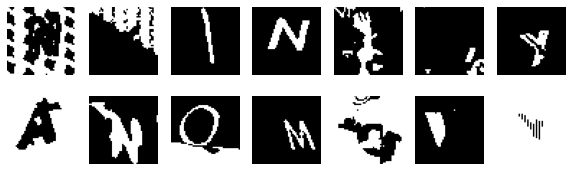

In [ ]:
separator=0.5
visualize(to_black_white(test,separator),len(to_black_white(test, separator))) # embos with 0.5 #edge detection 1 with 0.5